<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze thalamic projections to frontal cortex using a 3D light sheet microscopy dataset from whole mouse brains. While this tutorial focuses on thalamocortical connectivity, the dataset contains connections between the frontal cortex and other brain regions, which have yet to be thoroughly explored. 
    
**Dataset:**  This dataset was collected using the mesoscale anatomy platform established at the Allen Institute for Neural Dynamics. Brain samples are cleared and imaged on a SmartSPIM lightsheet microscope. Images are stitched and fused into a 3D volume and aligned to the Common Coordinate Framework (CCF), which allows for integration between samples. Candidate cell somas are algorithmically detected and then classified as true detections or non-cells using a trained deep neural network. This yields a collection of cells throughout the brain, each of which are localized within CCF space. The datasets in this tutorial have been QC'd to verify accurate cell detection, but this verification has been primarily performed in thalamus. Care should be taken to verify cell counts in other regions before drawing strong conclusions. 
    
**Experiment:** These experiments are focused on the structure of inputs to frontal cortex. Retrograde viruses were injected across the frontal cortex, eliciting expression of nuclear-localized fluorophores in infected cells. These injections label somas at the site of virus delivery, as well as the somas of neurons with axonal projections to that location. The brains in this dataset received 1-3 injections of viruses expressing spectrally distinct fluorophores, and thus each injection is conceptualized as an independent connectivity mapping experiment. While the majority of these viral injections employed AAVrg-XFPs, other reagents were also used to address potential cellular or axonal density based tropism. The location of each injection site was empirically determined.
        
    
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data<br>
    
    

In [1]:
# general imports 

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

import pandas as pd
%matplotlib inline

In [2]:
# specific imports and brain atlas initialization 

from load_data import load_data
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', 
                        check_latest = False) # load CCF mouse brain atlas, 25um resolution 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load data for a single brain 
      
The load_data object class is a wrapper for pulling relevant lightsheet data and data products from the /data folders for a given mouse ID. Here, we'll load the data for a single mouse_ID.  

You'll see which channels passed through each stage of processing: 
raw image channels > cell detection model applied > transformation to CCF space). The 639 channel is used for imaging autofluorescent tissue (background), so there should not be detected cells. 

In [3]:
help(load_data)

Help on class load_data in module load_data:

class load_data(builtins.object)
 |  load_data(sample, level=3)
 |  
 |  A class to load, process, and analyze whole-brain volumetric imaging data for a specified mouse ID. 
 |  
 |  Parameters
 |  -----------
 |  sample : int or str 
 |      Mouse ID (e.g., 689305) 
 |  
 |  level : int, optional 
 |      Resolution level for loading volumetric imaging data. Range: 0 - 4, higher numbers equate to greater downsampling.      
 |      Default = 3.  
 |  
 |  Attributes 
 |  ----------
 |  baseResolution : list of float
 |      Base voxel resolution in microns: [1.8, 1.8, 2]
 |      
 |  zarrMultiple : dict 
 |      A dictionary mapping Zarr resolution levels to their corresponding compression factors 
 |      
 |  rootDir : pathlib.Path 
 |      Root directory for the mouse ID data. 
 |      
 |  channels : list of str 
 |      List of imaging channels (e.g., ["488", "561"]) in the dataset 
 |      
 |  chPaths : dict 
 |      Dictionary mapp

In [4]:
mouse_ID = 693198
x = load_data(mouse_ID)

Loading data from ../data/SmartSPIM_693198_2023-10-02_16-39-10_stitched_2024-01-11_13-20-45/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Save the list of channels that passed through cell segmentation and CCF alignment for future reference.

In [5]:
channels = list(x.quantPaths.keys())
channels

['445', '488', '561']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

#### Reference metadata 
      
**Task 1:** Using the metadata dataframe, what experimental information do we have about this mouse_ID? 

In [6]:
# metadata_df = pd.read_csv('/scratch/metadata.csv')
metadata_df = pd.read_csv('/data/metadata.csv')

metadata_df[metadata_df.subject_id == mouse_ID]

,Unnamed: 0,name,subject_id,genotype,sex,virus,titer,ap,ml,dv,volume,age_days,days_to_perfusion,qc_tissue,ng_link,channel,qc_channel,ng_channel,inj_coordinates
46,46,SmartSPIM_693198_2023-10-02_16-39-10_stitched_...,693198,wt/wt,Male,AAVrg-Syn-H2B-Turquoise,2.960000e+14,2.0,1.4,0.6,50.0,38,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,445,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 130, 'ML': 299, 'DV': 89}"
47,47,SmartSPIM_693198_2023-10-02_16-39-10_stitched_...,693198,wt/wt,Male,AAVrg-Syn-H2B-tdTomato,5.100000e+13,2.4,0.6,1.0,50.0,38,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,561,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 122, 'ML': 263, 'DV': 106}"
48,48,SmartSPIM_693198_2023-10-02_16-39-10_stitched_...,693198,wt/wt,Male,AAVrg-Syn-H2B-EGFP,1.360000e+14,2.4,1.0,1.0,50.0,38,28,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,488,Pass,https://aind-neuroglancer-sauujisjxq-uw.a.run....,"{'AP': 114, 'ML': 275, 'DV': 103}"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Visualization Tools  
    
We can look at the imaging data using [neuroglancer](https://github.com/google/neuroglancer), a webGL based tool for visualizing and exploring large volumetric anatomy datasets  
    
[Neuroglancer interface basics](https://allenswdb.github.io/anatomy/microns-em/em-neuroglancer.html)  
    
The metadata dataframe has a few neuroglancer links for each subject_id that shows that passed through different processing steps, such as cell segmentation, ccf alignment, and cell counting. 

 

In [7]:
# View Stitched Volumetric Imaging Data 

ch = 561 # pick a channel to look at 

# filter metadata_df for subject_id and channel of interest, pull ng_link 
stitched_link = metadata_df[(metadata_df.subject_id == mouse_ID) & (metadata_df.channel == ch)].ng_link.tolist()[0]

# renders the link clickable 
HTML(f'<a href="{stitched_link}" target="_blank">{stitched_link}</a>')


In [8]:
# view a single channel with cell segmentation applied 

# filter metadata_df for subject_id and channel of interest, pull ng_link 
segmentation_link = metadata_df[(metadata_df.subject_id == mouse_ID) & (metadata_df.channel == ch)].ng_channel.tolist()[0]

# renders the link clickable 
HTML(f'<a href="{segmentation_link}" target="_blank">{segmentation_link}</a>')

In [9]:
# view cell counts in each brain structure 

cell_segmentation_ccf_link = 'https://aind-neuroglancer-sauujisjxq-uw.a.run.app/#!%7B%22dimensions%22:%7B%22z%22:%5B0.000024999999999999998%2C%22m%22%5D%2C%22y%22:%5B0.000024999999999999998%2C%22m%22%5D%2C%22x%22:%5B0.000024999999999999998%2C%22m%22%5D%2C%22t%22:%5B0.001%2C%22s%22%5D%7D%2C%22position%22:%5B249.75%2C166.5%2C264.5%2C0.5%5D%2C%22crossSectionScale%22:0.5%2C%22projectionScale%22:1024%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22zarr://s3://aind-open-data/SmartSPIM_693198_2023-10-02_16-39-10_stitched_2024-01-11_13-20-45/image_atlas_alignment/Ex_561_Em_593/OMEZarr/image.zarr%22%2C%22localDimensions%22:%7B%22c%27%22:%5B1%2C%22%22%5D%7D%2C%22localPosition%22:%5B0.5%5D%2C%22tab%22:%22source%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B0%2C500%5D%7D%7D%2C%22name%22:%22image_25_um%22%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%22precomputed://s3://aind-open-data/SmartSPIM_693198_2023-10-02_16-39-10_stitched_2024-01-11_13-20-45/image_cell_quantification/Ex_561_Em_593/visualization/cell_points_precomputed%22%2C%22tool%22:%22annotatePoint%22%2C%22tab%22:%22annotations%22%2C%22name%22:%22cell_points%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://s3://aind-open-data/SmartSPIM_693198_2023-10-02_16-39-10_stitched_2024-01-11_13-20-45/image_cell_quantification/Ex_561_Em_593/visualization/ccf_cell_precomputed%22%2C%22tab%22:%22source%22%2C%22name%22:%22cell_counting_in_CCF%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22image_25_um%22%7D%2C%22layout%22:%224panel%22%7D'

HTML(f'<a href="{cell_segmentation_ccf_link}" target="_blank">{cell_segmentation_ccf_link}</a>')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Automated Cell Detection**  
    
With this dataset, we can map which brain regions provide input to the frontal cortex. To do so, we need to find all of the cells labelled by each viral injection, and the locations of those cells in the brain. Manually annotating these cells is quite laborious, especially at the whole brain scale. To facilitate quantitative insights from these experiments, cells were automatically detected using machine vision models. The rest of this tutorial will show you how to load and analyze the spatial coordinates of these detected cells.  
    
The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. Note that these coordinates are transformed into CCF space. 

In [10]:
help(x.getCellsCCFdf)

Help on method getCellsCCFdf in module load_data:

getCellsCCFdf(ch: list) method of load_data.load_data instance
    Retrieves and formats CCF transformed coordinates of segmented cells into a dataframe. 
    
    Parameters
    ----------
    ch : list of str 
        List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]). 
    
    Returns
    -------
    location_df : pd.DataFrame
        Dataframe where each row is a cell and each column is a coordinate: AP (anterior-posterior), DV (dorsal-ventral), or ML (medial-lateral), with an additional "channel" column indicating the channel of origin.



In [11]:
cellLocs = x.getCellsCCFdf(channels)
cellLocs

,AP,DV,ML,channel
0,236,29,308,445
1,237,27,299,445
2,244,34,330,445
3,244,41,340,445
4,241,44,349,445
...,...,...,...,...
724274,291,263,101,561
724275,299,266,101,561
724276,297,266,105,561
724277,300,269,108,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** How many cells were detected in a single channel? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Plot histograms of the cell locations** 

Another way to visualize and explore the data is by plotting histograms of the cell coordinates embedded within the anatomical structures. Since this project is focused on mapping thalamocortical connections, we'll take a slice of the brain centered around the thalamus and plot a histogram of the spatial coordinates of the cells targeted in that region. We'll plot in the coronal plane. Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are. 
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions. 

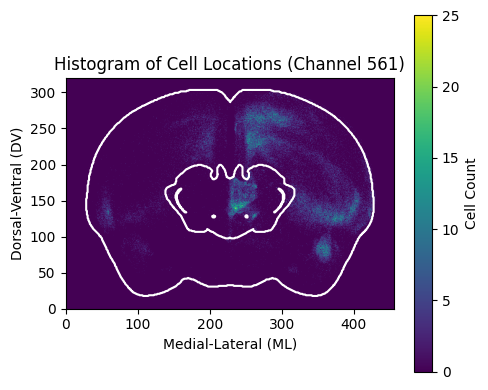

In [12]:
ch = '561' # select a channel 
plane = 250 # anterior-posterior slice to plot 
window = 100# slice window bounds 
roiList = ["root", "TH"] # brain structures to plot 

# set figure parameters 
fig, ax = plt.subplots(figsize=(5, 4))

# generate the histogram of cell coordinates
planeLocs = cellLocs.loc[(cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :] # filter cellLocs to coordinates within AP slice bounds

# calculate bins for histogram 
xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1) 
ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)

# create histogram of ML, DV coordinates 
hist, xedges, yedges = np.histogram2d(
    planeLocs[planeLocs['channel'] == ch]["ML"],
    planeLocs[planeLocs['channel'] == ch]["DV"],
    bins=(xbins, ybins))

# overlay the heatmap 
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap = ax.imshow(
    hist.T,  # transpose because imshow expects (rows, cols)
    extent=extent,
    origin="upper",
    cmap="viridis",
    alpha=1)

# generate contour outlines for brain structures
for roi in roiList:
    roi_mask = atlas.get_structure_mask(roi) # creates a binary array the size of the brain, mask out brain structures of interest 
    ax.contour(roi_mask[plane, :, :],
        levels=[0.5],
        colors="white",
        linewidths=1.5,
        origin="upper") # plotting features for structure outline 

# add colorbar and labels 
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Cell Count")
ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
ax.set_xlabel("Medial-Lateral (ML)")
ax.set_ylabel("Dorsal-Ventral (DV)")

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Compare cell counts across brain strutures** 
    
We can use the `getcellcounts` function to load a dataframe of the cell counts in each brain structure. 

| Column    | Description |
| -------- | ------- |
| ID  | number id of brain structure   |
| Acronym | shorthand name of brain structure     |
| Name | full name of brain structure     |
| Struct_Info    | mid = structure crosses the midline, hemi = structure disconnected across midline  |
| Struct_area_um3   | volume of brain structure    |
| Left    | left hemisphere cell counts    |
| Right    | right hemisphere cell counts   |
| Total    | total cell counts   |
| Left_Density    | density of cells in left hemisphere of brain structure  |
| Right_Density    | density of cells in right hemisphere of brain structure  |
| Total_Density    | density of cells in total brain structure   |
| channel    | channel name    |

In [13]:
help(x.getcellcounts)

Help on method getcellcounts in module load_data:

getcellcounts(ch: list) method of load_data.load_data instance
    Imports the cell_counts_by_region.csv (quantification of detected cells in brain regions) as a dataframe 
    
        Parameters
        ----------
        ch : list of str 
            List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]). 
    
        Returns
        -------
        cell_counts_df : pd.DataFrame
            DataFrame where each row is a brain region cell count in a given channel



In [14]:
cell_counts_df = x.getcellcounts(channels) # a row for each structure in the CCF ontology (838) 
cell_counts_df 

,ID,Acronym,Name,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density,channel
0,997,root,root,mid,5.113271e+11,75190,194268,269458,2.940974e-07,7.598580e-07,5.269777e-07,445
1,8,grey,Basic cell groups and regions,hemi,2.312776e+11,74694,192062,266756,3.229626e-07,8.304394e-07,5.767010e-07,445
2,567,CH,Cerebrum,hemi,1.414069e+11,74086,189559,263645,5.239207e-07,1.340521e-06,9.322211e-07,445
3,688,CTX,Cerebral cortex,hemi,1.137573e+11,74037,189422,263459,6.508329e-07,1.665141e-06,1.157987e-06,445
4,695,CTXpl,Cortical plate,hemi,1.093212e+11,73854,187417,261271,6.755690e-07,1.714370e-06,1.194970e-06,445
...,...,...,...,...,...,...,...,...,...,...,...,...
2509,129,V3,third ventricle,mid,1.139386e+09,5,10,15,8.776659e-09,1.755332e-08,1.316499e-08,561
2510,140,AQ,cerebral aqueduct,mid,4.506497e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2511,145,V4,fourth ventricle,mid,1.372785e+09,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561
2512,153,V4r,lateral recess,hemi,3.813698e+08,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Construct a Connectivity Matrix** 

To help us assess the connectivity across brain regions, we can use cell_counts_df to construct a connectivity matrix.  
    
First, filter the cell counts dataframe to cells within thalamic subregions. Here, we will use the acronym name and look at the leaf node structures (e.g. finest parcellated structures within thalamus). Next, use pivot_table to tabulate the connectivity matrix. Rows = channels, columns = brain structure, values = total cell counts

In [15]:
# thalamic subregions of interest (leaf nodes) 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cell_counts_df = cell_counts_df[cell_counts_df["Acronym"].isin(roiList)] 

conn_mat = filtered_cell_counts_df.pivot_table(index = "channel", 
                                      columns = "Acronym", 
                                      values = "Total")
conn_mat

Acronym,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,45,424,1,54,290,339,0,11
488,292,1916,335,517,2457,1151,59,549
561,375,1588,577,551,2615,887,130,908


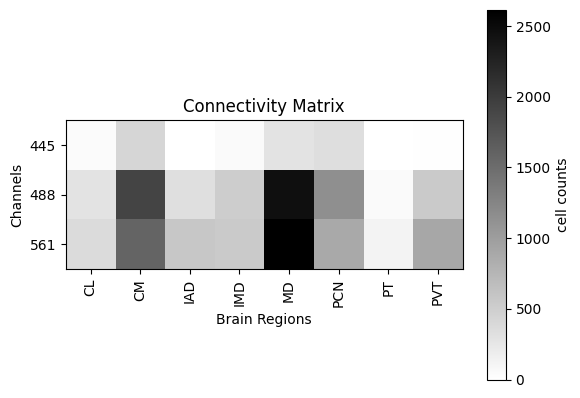

In [16]:
# plot the connectivity matrix as a heatmap 

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** Since each brain structure is variable in size, the total density might be more informative than the total cell counts. Try reconstructing the connectivity matrix and gridded heatmap using total density.    
      
    
**Bonus:** plot as an anatomical heatmap where each brain structure is shaded accordingly with the total density 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Load multiple datasets**  
    
A few helper functions to load data for multiple subject_ids and attach metadata information. 
    
`batch_process` will iterate through a list of IDs and output a dataframe of cell locations and a dataframe of cell counts per brain region for each channel within each ID.  
    
`add_metadata_info` can attach new columns with metadata information by merging the metadata_dataframe with another

In [17]:
def batch_process(id_list): 
    """
    Loads data for a list of subject_ids. 
    
    Parameters:
        id_list: List of subject_ids 

    Returns:
        cell_locations_df: pandas.DataFrame of cell locations with an additional subject_id column 
        cell_counts_df: pandas.DataFrame of cell counts in each brain structure with an additional subject_id column 
    """
    all_cell_locations = [] 
    all_cell_counts = [] 

    for mouse_ID in id_list: # runs load_data through a list of subject_ids 
        x = load_data(mouse_ID)
        channels = list(x.quantPaths.keys())

        if len(channels) > 0: # only run if there are processed channels with the subject_id data 
            cell_locations = x.getCellsCCFdf(channels) # get cell segmentations in CCF 
            cell_locations = cell_locations.assign(subject_id = mouse_ID) # attach new column w subject_id 
            all_cell_locations.append(cell_locations) 

            cell_counts = x.getcellcounts(channels) # get cell counts by brain structure 
            cell_counts = cell_counts.assign(subject_id = mouse_ID) # attach new column w subject_id 
            all_cell_counts.append(cell_counts) 

        else: 
            pass 

    cell_locations_df = pd.concat(all_cell_locations) # concatenate dataframes for each subject_id 
    cell_counts_df = pd.concat(all_cell_counts) 
    
    return cell_locations_df, cell_counts_df 


def add_metadata_info(data_df, metadata_df, key_columns, additional_columns):
    """
    Cross-references a dataframe with a metadata dataframe based on key columns (subject_id and channel) and adds additional columns from metadata_df. 
    
    Parameters:
        data_df: pandas.DataFrame containing the data to add metadata information to. 
        metadata_df: pandas.DataFrame containing metadata information. 
        key_columns: list of str column names to use as keys for matching (e.g. ['subject_id', 'channel']
        additional_columns: list of str column names from metadata_df to add to data_df. 
        
    Returns:
        merged_df: Updated DataFrame with original data_df and merged columns from metadata_df 

    """
    # Converts data within key columns to str 
    for key in key_columns:
        data_df[key] = data_df[key].astype(str)  # Convert to string
        metadata_df[key] = metadata_df[key].astype(str)  # Convert to string

    # Filter metadata_df based on key_columns to match and additional_columns 
    metadata_subset = metadata_df[key_columns + additional_columns]
    
    # Merge data_df and metadata_df based on key columns 
    merged_df = data_df.merge(metadata_subset, on=key_columns, how='left')
    
    return merged_df

In [18]:
# Example use case: 

# # get list of subject_ids that fit a few criteria referencing the metadata_df 
id_list = metadata_df[(metadata_df.qc_tissue == "Pass") & 
                     (metadata_df.qc_channel == "Pass") & 
                     metadata_df.virus.str.contains("AAV")].subject_id.unique().tolist()

#run id_list through batch_process, running a few at first to save time 
[cell_locations_df, cell_counts_df] = batch_process(id_list[0:2])

#attach metadata info 

#define key columns for cross-referencing between data_df and metadata_df 
key_columns = ["subject_id", "channel"] 

#define additional columns to add 
additional_columns = ["virus", "inj_structure"]

#add metadata to cell_locations_df and cell_counts_df 
cell_locations_with_metadata = add_metadata_info(cell_locations_df, metadata_df, key_columns, additional_columns)
cell_counts_with_metadata = add_metadata_info(cell_counts_df, metadata_df, key_columns, additional_columns)


Loading data from ../data/SmartSPIM_679519_2023-08-15_11-43-09_stitched_2023-08-22_22-13-20/image_tile_fusing/OMEZarr
Found the following channels: ['488', '561', '639']
Found cell segmentations in the following channels: ['488', '561']
Found CCF aligned quantifications in the following channels: ['488', '561']
Loading data from ../data/SmartSPIM_689237_2023-08-30_19-04-37_stitched_2023-09-12_08-06-57/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']


KeyError: "['inj_structure'] not in index"

In [19]:
# Generate connectivity matrix and plot heatmap of cell counts 

# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cell_counts_df = cell_counts_with_metadata[cell_counts_with_metadata["Acronym"].isin(roiList)] 


conn_mat = filtered_cell_counts_df.pivot_table(index = "inj_structure", 
                                      columns = "Acronym", 
                                      values = "Total")

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Injection Site")
plt.show()

NameError: name 'cell_counts_with_metadata' is not defined

 Questions to explore further: 

* Can you predict x metadata from y measurement? (e.g. predict injection coordinates from labelled structures) 

* Does the virus identity matter? Assess the variability in targeted expression across injection sites. 

* Is there spatial topography in the labelling? 

* Explore expression patterns beyond the thalamus. Some starting points: amygdala, other cortial areas, locus coeruleus. 
    
* Apply data-driven parcellations to the spatial coordinates of detected cells such as NMF 


